In [1]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import image as mpimg

In [2]:
mydataset = dataiku.Dataset("new_train")
total=mydataset.get_dataframe()
infodata = dataiku.Dataset("info")
info=infodata.get_dataframe()
total=total.to_numpy()
train, test=train_test_split(total,test_size=0.20,random_state=256)
train, val=train_test_split(train,test_size=0.10,random_state=256)

In [3]:
#total=pd.DataFrame(total)

In [4]:
info=info.sort_values('strip_id')

In [5]:
info=info.set_index('strip_id')

In [6]:
info

,device_bin_code,equipment_name,time
strip_id,,,
0.0,"521,",INSP-ACA-AWB2D2-002,2023-09-01 23:41:18
1.0,"521,517,",INSP-ACA-AWB2D2-002,2023-09-01 23:41:18
2.0,"516,",INSP-ACA-AWB2D2-002,2023-09-01 23:41:18
3.0,"530,530,530,",INSP-ACA-AWB2D2-002,2023-08-30 23:42:38
4.0,"530,530,530,530,530,530,530,530,530,",INSP-ACA-AWB2D2-002,2023-08-30 23:42:38
...,...,...,...
876.0,"518,",INSP-ACA-AWB2D2-018,2023-08-29 23:59:55
877.0,"516,",INSP-ACA-AWB2D2-018,2023-08-29 23:59:55
878.0,"516,",INSP-ACA-AWB2D2-009,2023-08-30 23:45:17


In [7]:
itrain,itest=train_test_split(info,test_size=0.20,random_state=256)

In [8]:
#total=np.reshape(total,(-1,12,4))

In [9]:
total.shape

(881, 48)

In [10]:
train.shape

(633, 48)

In [11]:
#train=np.reshape(train,(-1,12,4))

In [12]:
#test=np.reshape(test,(-1,12,4))

In [13]:
test.shape

(177, 48)

In [14]:
#val=np.reshape(val,(-1,12,4))

In [15]:
val.shape

(71, 48)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,Reshape,Lambda,LeakyReLU,Dropout,BatchNormalization,Conv1D,Conv2D,Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.losses import MeanSquaredError,BinaryCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from keras.utils.visualize_util import plot

In [17]:

trainf=tf.expand_dims(train, axis=-1)
valf=tf.expand_dims(val, axis=-1)
testf=tf.expand_dims(test, axis=-1)
totalf=tf.expand_dims(total, axis=-1)

In [18]:
trainf.shape

TensorShape([633, 48, 1])

In [19]:
#trainf

In [20]:
def _parse_function(filename, channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image 

In [21]:
#trainf[632]

In [22]:
#plt.imshow(trainf[632])

In [23]:
#plt.imshow(totalf[632])

In [24]:
tf.keras.backend.clear_session()

In [25]:
#train = tf.cast(arr_train, tf.float32)
#test = tf.cast(arr_test, tf.float32)

In [26]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        #input_shape = (12, 12, 4, 1)
        self.encoder = tf.keras.Sequential([
            #tf.keras.Input(shape=(None,64)),
            tf.keras.layers.InputLayer(input_shape=(48,1)),
            #Reshape((12,4,1)),
            Conv1D(32, 7, activation='relu',input_shape=(48,1)),
            Conv1D(16, 7, activation='relu'),
            #Conv1D(8, 7, activation='relu'),
            #Conv1D(4, 7, activation='relu'),
            #Conv2D(1, 2, activation=LeakyReLU(alpha=0.01),input_shape=(10,2,1)),
            #Conv2D(2, 3, activation=LeakyReLU(alpha=0.01),input_shape=(8,4,1)),
            Flatten(),
            #Dense(16,activation=LeakyReLU(alpha=0.01)),
            #BatchNormalization(),
            #Dense(8,activation=LeakyReLU(alpha=0.01)),
            #BatchNormalization(),
            #Dense(4,activation=LeakyReLU(alpha=0.01)),
            #BatchNormalization(),
            #Dropout(0.1),
            Dense(2),
            BatchNormalization(),
        ]
        )

        self.decoder = tf.keras.Sequential([
            Dense(2,activation=LeakyReLU(alpha=0.01)),
            #Dropout(0.2),
            BatchNormalization(),
            Dense(4,activation=LeakyReLU(alpha=0.01)),
            BatchNormalization(),
            Dense(8,activation=LeakyReLU(alpha=0.01)),
            #Dropout(0.2),
            BatchNormalization(),
            Dense(16,activation=LeakyReLU(alpha=0.01)),
            BatchNormalization(),
            Dense(32,activation=LeakyReLU(alpha=0.01)),
            #Dropout(0.2),
            BatchNormalization(),
            Dense(48,activation='sigmoid'),
            Reshape((48,1))
        ]
        )
    def encode(self,x):
        encoded = self.encoder(x)
        return encoded

    def decode(self, x):
        decoded = self.decoder(x)
        return decoded
 
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
class MyCallback(tf.keras.callbacks.Callback):

    def __init__(self, patience=0):
        super(MyCallback, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        tf.print(self.model.get_weights())

In [28]:
epochs=30
lr=0.001
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,cooldown=1,
                              patience=3, min_lr=0.000001, verbose=1)
#def scheduler(epochs,lr):
#    if epoch<=5 :
#        return lr
#    else:
#        return lr*tf.math.exp(-0.1)
callbacks = [reduce_lr
            ]

In [29]:
#lr_scheduler=PolynomialDecay()

In [30]:
autoencoder= AutoEncoder()

In [31]:
#autoencoder.build()

In [32]:
autoencoder.compile(optimizer='adam',loss=BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [33]:
history=autoencoder.fit(totalf,totalf,epochs=epochs,validation_data=(valf,valf),callbacks=callbacks)

Epoch 1/30
28/28 [==============================] - 3s 12ms/step - loss: 0.9558 - accuracy: 0.5507 - val_loss: 0.9506 - val_accuracy: 0.7031
Epoch 2/30
28/28 [==============================] - 0s 4ms/step - loss: 0.9429 - accuracy: 0.6406 - val_loss: 0.9428 - val_accuracy: 0.8087
Epoch 3/30
28/28 [==============================] - 0s 4ms/step - loss: 0.9263 - accuracy: 0.7107 - val_loss: 0.9248 - val_accuracy: 0.8991
Epoch 4/30
28/28 [==============================] - 0s 4ms/step - loss: 0.9034 - accuracy: 0.7616 - val_loss: 0.8885 - val_accuracy: 0.9531
Epoch 5/30
28/28 [==============================] - 0s 4ms/step - loss: 0.8721 - accuracy: 0.8096 - val_loss: 0.8415 - val_accuracy: 0.9589
Epoch 6/30
28/28 [==============================] - 0s 4ms/step - loss: 0.8420 - accuracy: 0.8435 - val_loss: 0.8037 - val_accuracy: 0.9269
Epoch 7/30
28/28 [==============================] - 0s 5ms/step - loss: 0.8100 - accuracy: 0.8851 - val_loss: 0.7735 - val_accuracy: 0.9460
Epoch 8/30
28/28 [=

In [34]:
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 5018      
_________________________________________________________________
sequential_1 (Sequential)    (None, 48, 1)             2578      
Total params: 7,596
Trainable params: 7,468
Non-trainable params: 128
_________________________________________________________________


In [35]:
#get layer shape 
layers = autoencoder.layers
#first_layer = layers[0] # usually the first layer is the input layer
#print(first_layer.input_shape)  
#print(autoencoder.layers[1].input_shape[0])
for i, layer in enumerate(autoencoder.encoder.layers):
    print(f"Layer {i}:")
    #input_tensor = layer.input
    #output_tensor = layer.output
    try:
        weights=layer.get_weights()[0].shape
    except:
        #print(exception)
        pass
    print(f"weights: {weights}")
    print(f"Input shape: {layer.input_shape}")
    print(f"Output shape: {layer.output_shape}")

Layer 0:
weights: (7, 1, 32)
Input shape: (None, 48, 1)
Output shape: (None, 42, 32)
Layer 1:
weights: (7, 32, 16)
Input shape: (None, 42, 32)
Output shape: (None, 36, 16)
Layer 2:
weights: (7, 32, 16)
Input shape: (None, 36, 16)
Output shape: (None, 576)
Layer 3:
weights: (576, 2)
Input shape: (None, 576)
Output shape: (None, 2)
Layer 4:
weights: (2,)
Input shape: (None, 2)
Output shape: (None, 2)


In [36]:
loss_values = history.history['loss']
val_loss=history.history['val_loss']

In [37]:
accuracy=history.history['accuracy']
val_acc=history.history['val_accuracy']

In [38]:
#loss_values

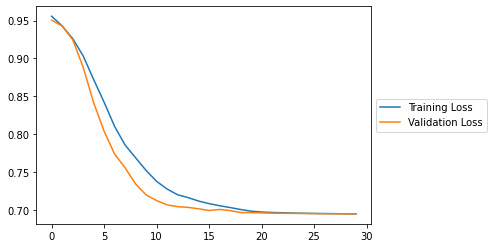

In [39]:
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

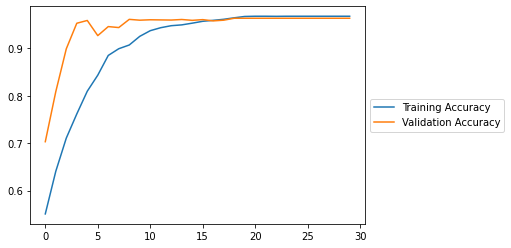

In [40]:
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [41]:
encode_train=autoencoder.encode(trainf)

In [42]:
decode_train=autoencoder.decode(encode_train)

In [43]:
encode_train

<tf.Tensor: shape=(633, 2), dtype=float32, numpy=
array([[ 0.3789575 , -1.2664014 ],
       [-0.64785075, -0.2798856 ],
       [-0.5143453 ,  0.71015906],
       ...,
       [ 1.1922355 ,  1.0309862 ],
       [-1.9115372 , -1.2402143 ],
       [ 2.6522841 ,  0.97554505]], dtype=float32)>

In [44]:
decode_train

<tf.Tensor: shape=(633, 48, 1), dtype=float32, numpy=
array([[[0.00238545],
        [0.00371129],
        [0.00225929],
        ...,
        [0.00343212],
        [0.00287213],
        [0.00305542]],

       [[0.00258826],
        [0.00387709],
        [0.00242238],
        ...,
        [0.00344064],
        [0.00293347],
        [0.00323281]],

       [[0.00291344],
        [0.00399154],
        [0.00256863],
        ...,
        [0.00329537],
        [0.00291579],
        [0.00369062]],

       ...,

       [[0.00252436],
        [0.00378962],
        [0.00238707],
        ...,
        [0.00281707],
        [0.00175126],
        [0.00329219]],

       [[0.00582054],
        [0.00246272],
        [0.00429492],
        ...,
        [0.00238161],
        [0.00220023],
        [0.00384413]],

       [[0.00228628],
        [0.00200083],
        [0.00233314],
        ...,
        [0.00383248],
        [0.00296914],
        [0.00543128]]], dtype=float32)>

In [45]:
encode_train_df=pd.DataFrame(encode_train.numpy(),columns = ['x','y'])

In [46]:
#decode_train_df=pd.DataFrame(decode_train.numpy())

In [47]:
encode_train_df

,x,y
0,0.378958,-1.266401
1,-0.647851,-0.279886
2,-0.514345,0.710159
3,-1.151906,-0.346298
4,2.129680,0.565726
...,...,...
628,-0.286116,-0.273933
629,-0.549200,-0.383638
630,1.192235,1.030986
631,-1.911537,-1.240214


In [48]:
#decode_train_df

#not used currently
import math
def sigmoid(x): 
    return np.clip(1 / (1 + np.exp(-x)), 0.000001, 0.999999)
decode_test_df = decode_train_df.applymap(sigmoid)

In [49]:
#decode_train_df

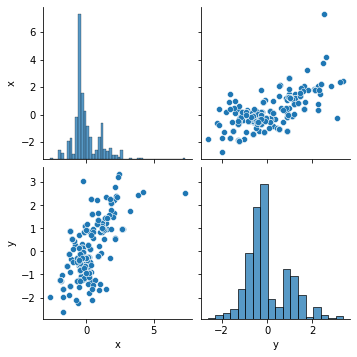

In [50]:
sns.pairplot(encode_train_df)

In [51]:
encode_test=autoencoder.encode(testf)
encode_test_df=pd.DataFrame(encode_test.numpy(),columns = ['x','y'])

In [52]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [53]:
dbscan=DBSCAN(eps = 0.0001, min_samples =2)
dbscan.fit(encode_train_df[['x']],encode_train_df[['y']])
encode_train_df['dbs']=dbscan.labels_

In [54]:
dbscan.fit_predict(encode_test_df[['x']],encode_test_df[['y']])
encode_test_df['dbs']=dbscan.labels_

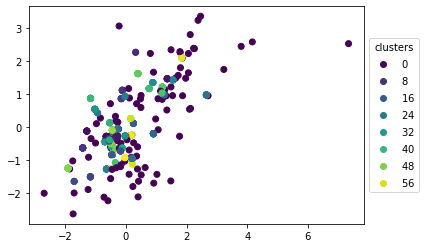

In [55]:
sc=plt.scatter(x=encode_train_df[['x']],y=encode_train_df['y'],c=encode_train_df['dbs'])
plt.legend(*sc.legend_elements(), title='clusters',loc='center left', bbox_to_anchor=(1, 0.5))

In [56]:
encode_train_df['dbs'].value_counts()

-1     100
 16     29
 6      24
 3      21
 4      19
 0      18
 21     18
 20     17
 18     17
 37     14
 9      14
 28     14
 23     14
 43     14
 31     13
 19     13
 12     13
 45     11
 44     10
 34     10
 49     10
 14     10
 48     10
 41      9
 22      9
 5       9
 30      8
 53      8
 40      8
 33      7
 55      7
 29      7
 8       7
 26      7
 25      7
 11      7
 51      7
 35      6
 2       6
 58      6
 10      6
 17      6
 1       6
 27      6
 32      5
 57      5
 38      5
 15      4
 36      3
 47      3
 13      3
 54      3
 24      2
 39      2
 50      2
 7       2
 60      2
 56      2
 52      2
 42      2
 46      2
 59      2
Name: dbs, dtype: int64

In [57]:
encode_train_df[encode_train_df['dbs']==20]

,x,y,dbs
33,-0.677253,-0.414627,20
69,-0.677253,-0.414627,20
73,-0.677253,-0.414627,20
84,-0.677253,-0.414627,20
98,-0.677253,-0.414627,20
103,-0.677253,-0.414627,20
141,-0.677253,-0.414627,20
178,-0.677253,-0.414627,20
211,-0.677253,-0.414627,20
250,-0.677253,-0.414627,20


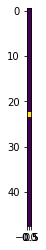

In [58]:
plt.imshow(trainf[37])

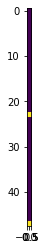

In [59]:
plt.imshow(trainf[150])

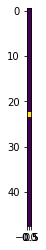

In [60]:
plt.imshow(trainf[189])

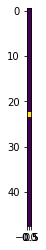

In [61]:
plt.imshow(trainf[234])

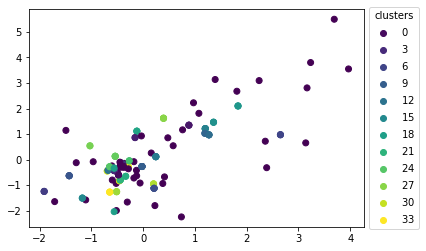

In [62]:
sc=plt.scatter(x=encode_test_df[['x']],y=encode_test_df['y'],c=encode_test_df['dbs'])
plt.legend(*sc.legend_elements(), title='clusters',loc='center left', bbox_to_anchor=(1, 0.5))

In [63]:
c=encode_test_df.dbs.value_counts()
clusters=pd.DataFrame(c)

In [64]:
clusters.drop(index=-1,inplace=True)

In [65]:
clusters=clusters.reset_index()
clusters=clusters.rename(columns={'dbs':'size','index':'cluster_index'})

In [66]:
clusters

,cluster_index,size
0,3,9
1,18,8
2,4,7
3,9,7
4,7,5
5,14,5
6,13,5
7,0,5
8,27,4
9,25,4


In [67]:
encode_test_df[encode_test_df['dbs']==19]

,x,y,dbs
41,-0.12094,1.115824,19
119,-0.12094,1.115824,19
143,-0.12094,1.115824,19


In [68]:
encode_test_df[encode_test_df['dbs']==13]

,x,y,dbs
28,0.24541,0.117114,13
58,0.24541,0.117114,13
101,0.24541,0.117114,13
139,0.24541,0.117114,13
171,0.24541,0.117114,13


In [69]:
strip_list=[]
clusters['no_of_defect']=0
for index,row in clusters.iterrows():
    string=""
    bincode=""
    equip=""
    time=""
    sin_cluster=encode_test_df[encode_test_df['dbs']==row['cluster_index']]
    sin_cluster=sin_cluster.reset_index()
    strip_list=strip_list=sin_cluster['index'].tolist()
    clusters.loc[index,'no_of_defect']=np.count_nonzero(test[strip_list[0]]==1)*clusters.loc[index,'size']
    for strip in strip_list:
        print(strip)
        string=str(strip)+","+string
        print(itest.iloc[strip,0])
        bincode=str(itest.iloc[strip,0])+bincode
        print(itest.iloc[strip,1])
        equip=str(itest.iloc[strip,1])+equip
        print(itest.iloc[strip,2])
        time=str(itest.iloc[strip,2])+time
        clusters.loc[index,'strip_id']=string
        clusters.loc[index,'bincode']=bincode
        clusters.loc[index,'equipment']=equip
        clusters.loc[index,'time']=time


8
517,
INSP-ACA-AWB2D2-009
2023-09-04 00:06:25
10
518,
INSP-ACA-AWB2D2-007
2023-09-04 00:05:36
34
516,
INSP-ACA-AWB2D2-009
2023-09-04 23:52:52
46
2,
INSP-ACA-AWB2D2-013
2023-08-31 23:56:13
102
517,
INSP-ACA-AWB2D2-018
2023-08-27 23:43:27
128
261,
INSP-ACA-AWB2D2-006
2023-09-04 00:07:17
136
517,
INSP-ACA-AWB2D2-009
2023-09-03 00:15:34
145
261,
INSP-ACA-AWB2D2-006
2023-08-25 23:45:37
150
644,
INSP-ACA-AWB2D2-010
2023-09-03 00:12:50
37
516,
INSP-ACA-AWB2D2-018
2023-08-28 23:53:00
43
261,
INSP-ACA-AWB2D2-010
2023-09-04 00:04:47
56
518,
INSP-ACA-AWB2D2-005
2023-09-03 00:11:35
65
644,
INSP-ACA-AWB2D2-007
2023-08-28 23:52:14
68
530,
INSP-ACA-AWB2D2-002
2023-09-04 23:50:42
106
272,
INSP-ACA-AWB2D2-006
2023-09-04 23:50:28
121
518,518,518,518,
INSP-ACA-AWB2D2-018
2023-08-28 23:52:05
175
518,
INSP-ACA-AWB2D2-006
2023-08-29 23:58:38
9
2,
INSP-ACA-AWB2D2-013
2023-08-25 23:42:52
27
0,
nan
2023-08-30 23:42:38
71
644,
INSP-ACA-AWB2D2-018
2023-09-04 00:06:27
104
272,
INSP-ACA-AWB2D2-006
2023-08-25 23:4

In [70]:
clusters

,cluster_index,size,no_of_defect,strip_id,bincode,equipment,time
0,3,9,9,"150,145,136,128,102,46,34,10,8,","644,261,517,261,517,2,516,518,517,",INSP-ACA-AWB2D2-010INSP-ACA-AWB2D2-006INSP-ACA...,2023-09-03 00:12:502023-08-25 23:45:372023-09-...
1,18,8,8,"175,121,106,68,65,56,43,37,","518,518,518,518,518,272,530,644,518,261,516,",INSP-ACA-AWB2D2-006INSP-ACA-AWB2D2-018INSP-ACA...,2023-08-29 23:58:382023-08-28 23:52:052023-09-...
2,4,7,7,"124,114,109,104,71,27,9,","518,520,518,272,644,0,2,",INSP-ACA-AWB2D2-009INSP-ACA-AWB2D2-006INSP-ACA...,2023-08-29 23:53:392023-09-04 00:07:002023-09-...
3,9,7,7,"166,127,61,40,25,21,18,","530,518,518,516,296,530,516,",INSP-ACA-AWB2D2-006INSP-ACA-AWB2D2-018INSP-ACA...,2023-08-30 23:47:092023-08-25 23:44:582023-08-...
4,7,5,5,"161,160,59,55,16,","516,517,516,516,516,",INSP-ACA-AWB2D2-007INSP-ACA-AWB2D2-010INSP-ACA...,2023-09-04 23:52:352023-08-30 23:44:552023-08-...
5,14,5,5,"82,81,79,36,29,","517,518,644,518,2,",INSP-ACA-AWB2D2-006INSP-ACA-AWB2D2-007INSP-ACA...,2023-08-30 23:46:432023-09-04 00:06:572023-09-...
6,13,5,5,"171,139,101,58,28,","2,516,517,263,530,",INSP-ACA-AWB2D2-013INSP-ACA-AWB2D2-010INSP-ACA...,2023-08-29 23:55:342023-09-04 00:04:472023-08-...
7,0,5,5,"159,148,122,15,3,","516,517,513,644,530,",INSP-ACA-AWB2D2-010INSP-ACA-AWB2D2-007INSP-ACA...,2023-09-01 23:44:362023-08-29 23:59:552023-08-...
8,27,4,4,"125,90,80,74,","2,2,2,517,",INSP-ACA-AWB2D2-013INSP-ACA-AWB2D2-013INSP-ACA...,2023-08-26 23:56:472023-09-03 00:15:142023-09-...
9,25,4,4,"157,138,86,64,","2,516,516,516,",INSP-ACA-AWB2D2-013INSP-ACA-AWB2D2-010INSP-ACA...,2023-08-29 23:55:342023-08-31 23:54:332023-08-...


In [71]:
sin_cluster=sin_cluster.reset_index()

In [72]:
strip_list=sin_cluster['index'].tolist()

In [73]:
#strip_list

In [74]:
testf[150]

<tf.Tensor: shape=(48, 1), dtype=float64, numpy=
array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])>

In [75]:
testf[145]

<tf.Tensor: shape=(48, 1), dtype=float64, numpy=
array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])>

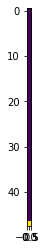

In [76]:
plt.imshow(testf[37])

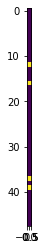

In [77]:
plt.imshow(testf[0])

In [78]:
itest.iloc[44,0]

'516,516,516,516,261,'

In [79]:
t=itest.iloc[44,0].split(',')

In [80]:
t

['516', '516', '516', '516', '261', '']

In [81]:
set(t)

{'', '261', '516'}

In [82]:
t.count('516')

4

In [83]:
max(set(t), key=t.count)

'516'

In [84]:
tnp=np.array(t)

In [85]:
unique, counts = np.unique(tnp, return_counts=True)

In [86]:
unique

array(['', '261', '516'], dtype='<U3')

In [87]:
counts

array([1, 1, 4])

In [88]:
index = np.argmax(counts)

In [89]:
tnp[index]

'516'

In [90]:
np.count_nonzero(test[10]==1)

1

In [91]:
encode_train_df['x'].shape

(633,)

In [92]:
mean_x=encode_train_df['x'].mean()

In [93]:
mean_y=encode_train_df['y'].mean()

In [94]:
var_x=np.power((encode_train_df['x']-mean_x),2).sum()/(948-1)

In [95]:
var_x

0.6483714376608698

In [96]:
var_y=np.power((encode_train_df['y']-mean_y),2).sum()/(948-1)

In [97]:
var_y

0.5814044634165457

In [98]:
cov=np.multiply((encode_train_df['x']-mean_x),(encode_train_df['y']-mean_y)).sum()/(948-1)

In [99]:
cov_mat=[[var_x,cov],[cov,var_y]]

In [100]:
cov_mat

[[0.6483714376608698, 0.41833808681403445],
 [0.41833808681403445, 0.5814044634165457]]

In [101]:
U, S, Vh = np.linalg.svd(cov_mat, full_matrices=True)

In [102]:
U

array([[-0.73477348, -0.67831256],
       [-0.67831256,  0.73477348]])

In [103]:
S

array([1.0345639 , 0.19521201])

In [104]:
Vh

array([[-0.73477348, -0.67831256],
       [-0.67831256,  0.73477348]])

In [105]:
#!pwd

In [106]:
#autoencoder.save_weights("model_weights2.h5")

In [107]:
#ls